In [9]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, accuracy_score
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
!unzip "BT100.zip" -d /content/

Archive:  BT100.zip
   creating: /content/BT100/
   creating: /content/BT100/Testing/
   creating: /content/BT100/Testing/glioma/
  inflating: /content/BT100/Testing/glioma/Te-glTr_0004.jpg  
  inflating: /content/BT100/Testing/glioma/Te-glTr_0009.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0013.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0014.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0017.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0018.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0021.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0023.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0024.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0025.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0026.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0028.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0029.jpg  
  inflating: /content/BT100/Testing/glioma/Te-gl_0030.jpg  
  inflating: /content/BT10

In [30]:
!unzip "newTesting.zip" -d /content/

Archive:  newTesting.zip
   creating: /content/Testing/
   creating: /content/Testing/glioma/
  inflating: /content/Testing/glioma/Te-glTr_0000.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0001.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0002.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0003.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0004.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0005.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0006.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0007.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0008.jpg  
  inflating: /content/Testing/glioma/Te-glTr_0009.jpg  
  inflating: /content/Testing/glioma/Te-gl_0010.jpg  
  inflating: /content/Testing/glioma/Te-gl_0011.jpg  
  inflating: /content/Testing/glioma/Te-gl_0012.jpg  
  inflating: /content/Testing/glioma/Te-gl_0013.jpg  
  inflating: /content/Testing/glioma/Te-gl_0014.jpg  
  inflating: /content/Testing/glioma/Te-gl_0015.jpg  
  inflating: /content/

In [3]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [4]:
train_dir = "BT100/Training"

# Define augmentation functions
def augment_image(image):
    """Apply rotation, flipping, zoom, brightness, and contrast adjustments."""

    # Random Rotation (-20 to +20 degrees)
    image = tf.image.rot90(image, k=random.choice([0, 1, 2, 3]))

    # Random Flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Zoom (Crop and Resize)
    crop_fraction = random.uniform(0.7, 1.0)  # Zoom range
    img_shape = tf.shape(image)

    # Cast img_shape elements to float32 before multiplication
    crop_size = [int(tf.cast(img_shape[0], tf.float32) * crop_fraction),
                 int(tf.cast(img_shape[1], tf.float32) * crop_fraction), 3]

    image = tf.image.random_crop(image, crop_size)
    image = tf.image.resize(image, (img_shape[0], img_shape[1]))

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

# Process each class in training folder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip if not a folder

    # Get image files
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_augmented = len(image_files)*2  # Generate 50% more images

    for i in range(num_augmented):
        img_name = random.choice(image_files)  # Pick a random image
        img_path = os.path.join(class_path, img_name)

        # Load image
        image = load_img(img_path)
        image = img_to_array(image) / 255.0  # Normalize

        # Apply augmentation
        augmented_image = augment_image(image)

        # Convert back to image
        augmented_image = array_to_img(augmented_image)

        # Save augmented image in the same folder
        new_filename = f"aug_{i}_{img_name}"
        augmented_image.save(os.path.join(class_path, new_filename))

print("Augmentation complete! Images saved in the existing training folder.")

Augmentation complete! Images saved in the existing training folder.


In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "BT100/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

Found 8574 files belonging to 4 classes.


In [31]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Testing",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

Found 1311 files belonging to 4 classes.


In [48]:
import os

train_dir = "BT100/Training"
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}: {len(os.listdir(class_path))} images")


glioma: 1983 images
pituitary: 2187 images
notumor: 2394 images
meningioma: 2010 images


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_refined_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_test = create_refined_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [34]:
myModel = model_test.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.3883 - loss: 2.4831 - val_accuracy: 0.6346 - val_loss: 0.9300 - learning_rate: 5.0000e-04
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6588 - loss: 0.8629 - val_accuracy: 0.7056 - val_loss: 0.8023 - learning_rate: 5.0000e-04
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7071 - loss: 0.7498 - val_accuracy: 0.7162 - val_loss: 0.6984 - learning_rate: 5.0000e-04
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7519 - loss: 0.6272 - val_accuracy: 0.7208 - val_loss: 0.6904 - learning_rate: 5.0000e-04
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7901 - loss: 0.5364 - val_accuracy: 0.7918 - val_loss: 0.5225 - learning_rate: 5.0000e-04
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8128 - loss: 0.4952 - val_accuracy: 0.8337 - val_loss: 0.4344 - learning_rate: 5.0000e-04
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Get true labels from test_data
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())

y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

# Get predictions from the model
y_pred = model_test.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Convert true labels to one-hot format
encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
y_pred_onehot = encoder.transform(y_pred.reshape(-1, 1))

# Print classification report
print(classification_report(y_true_onehot, y_pred_onehot, zero_division=1))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Accuracy: 0.919908466819222
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       300
           1       0.81      0.88      0.84       306
           2       0.95      0.98      0.96       405
           3       0.95      0.98      0.97       300

   micro avg       0.92      0.92      0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311
 samples avg       0.92      0.92      0.92      1311



41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


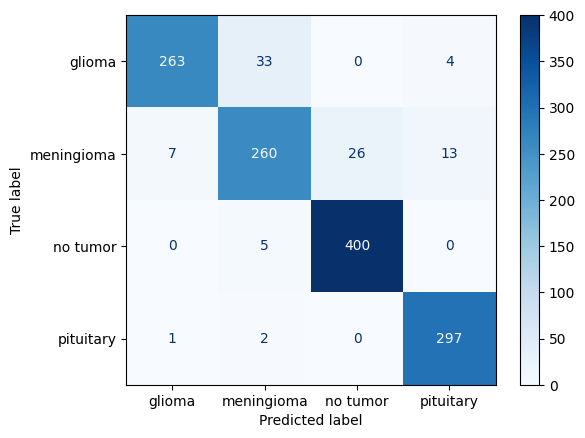

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma", "meningioma", "no tumor", "pituitary"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_true_labels, y_pred_labels, target_names=["glioma", "meningioma", "no tumor", "pituitary"]))


              precision    recall  f1-score   support

      glioma       0.97      0.88      0.92       300
  meningioma       0.87      0.85      0.86       306
    no tumor       0.94      0.99      0.96       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



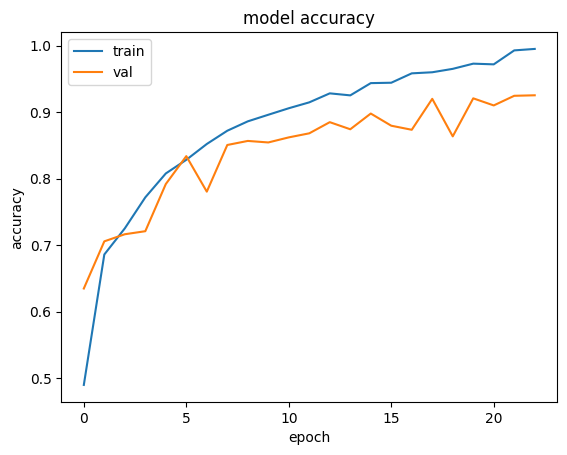

In [37]:
plt.plot(myModel.history['accuracy'])
plt.plot(myModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

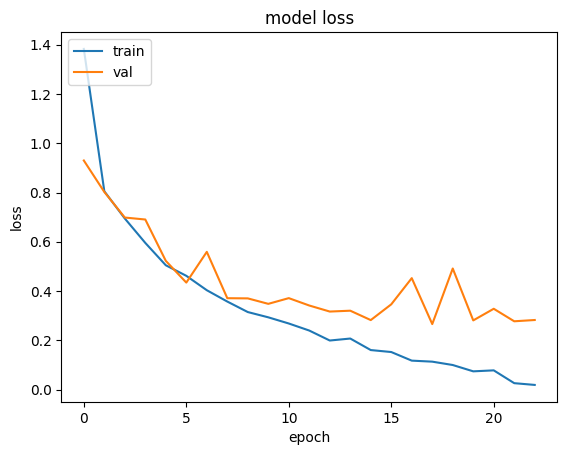

In [38]:
plt.plot(myModel.history['loss'])
plt.plot(myModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [40]:
model_test.save('my_model.h5')

In [55]:
import tensorflow as tf
import numpy as np
import cv2
import sys
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
MODEL_PATH = "my_model.h5"  # Change this if your model has a different name
model = tf.keras.models.load_model(MODEL_PATH)

# Define class labels
CLASS_LABELS = ["glioma", "meningioma", "no tumor", "pituitary"]

# Function to preprocess image
def preprocess_image(image_path):
    IMG_SIZE = (128, 128)  # Change this if your model uses a different size
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict tumor class
def predict_tumor(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    class_label = CLASS_LABELS[predicted_class]
    confidence = np.max(prediction) * 100

    print(f"Predicted Class: {class_label} ({confidence:.2f}%)")
    return class_label, confidence

if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python classify_tumor.py <image_path>")
    else:
        image_path = "Te-noTr_0009.jpg"
        predict_tumor(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Predicted Class: glioma (99.18%)
